
# Autoencoders: A Deep Dive

<div align="center">
  <img src="../assets/img/ae_1.png" width="800px"> </div>


### Introduction

Autoencoders are a type of artificial neural network used for unsupervised learning. They are designed to learn efficient data codings by projecting the input data into a lower-dimensional latent space and then reconstructing the original data from this representation. This process forces the autoencoder to capture the most important features of the input data.

### Architecture of an Autoencoder

A typical autoencoder consists of two main components:

* **Encoder:** This part of the network maps the input data to a latent space representation.
* **Decoder:** This part reconstructs the original data from the latent space representation.

The goal of training is to minimize the reconstruction error between the input and the reconstructed output.

### Types of Autoencoders

There are several variations of autoencoders:

* **Undercomplete Autoencoders:** These have a smaller latent space than the input space, forcing the network to learn a compressed representation of the data.
* **Denoising Autoencoders:** These are trained on corrupted input data, learning to reconstruct the original clean data.
* **Variational Autoencoders (VAEs):** These introduce probabilistic elements into the encoding process, allowing for generating new data samples.
* **Convolutional Autoencoders (CAEs):** These use convolutional layers, making them suitable for image data.

### Applications of Autoencoders

Autoencoders have a wide range of applications:

* **Dimensionality Reduction:** By projecting data into a lower-dimensional space, autoencoders can be used for visualization and feature extraction.
* **Image Denoising:** Denoising autoencoders can effectively remove noise from images.
* **Anomaly Detection:** Autoencoders can be used to identify unusual data points by measuring reconstruction errors.
* **Image Generation:** VAEs can generate new, realistic images based on the learned latent space distribution.
* **Data Compression:** Undercomplete autoencoders can be used for data compression.

### PyTorch Implementation

Let's implement a basic autoencoder using PyTorch for image compression:

In [25]:
import os
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from IPython.display import clear_output

os.chdir("../")

from src import data_loader
from src import ae

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Fashion MNIST Dataset

**Breakdown:**

1. **Import necessary libraries:**
   * `torchvision.transforms`: For image transformations.
   * `torchvision.datasets`: For loading the MNIST dataset.

2. **Define image transformations:**
   * `transforms.ToTensor()`: Converts PIL images to PyTorch tensors.
   * `transforms.Normalize()`: Normalizes tensor images with mean and standard deviation of 0.5.

3. **Load training data:**
   * `torchvision.datasets.FashionMNIST`: Loads the Fashion MNIST training dataset.
   * `root`: Specifies the data directory.
   * `train`: Set to `True` for training data.
   * `download`: Downloads the dataset if not present.
   * `transform`: Applies the defined transformations to the images.

4. **Load testing data:**
   * Similar to loading training data, but with `train=False` to load the test set.

In [26]:
batch_size = 32

# This gives us the loader object which is iterable and also has batches of data
train_loader = data_loader.load_mnist_data()

clear_output()

Let's explore a little about the size of data and also what is included in it.

In [27]:
for i, data_ in enumerate(train_loader):
    print(i, data_[0].shape)
    if i==10:
        break

0 torch.Size([32, 1, 28, 28])
1 torch.Size([32, 1, 28, 28])
2 torch.Size([32, 1, 28, 28])
3 torch.Size([32, 1, 28, 28])
4 torch.Size([32, 1, 28, 28])
5 torch.Size([32, 1, 28, 28])
6 torch.Size([32, 1, 28, 28])
7 torch.Size([32, 1, 28, 28])
8 torch.Size([32, 1, 28, 28])
9 torch.Size([32, 1, 28, 28])
10 torch.Size([32, 1, 28, 28])


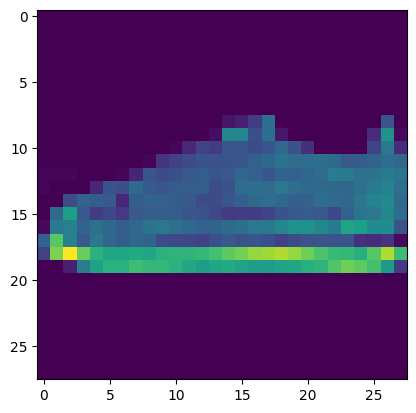

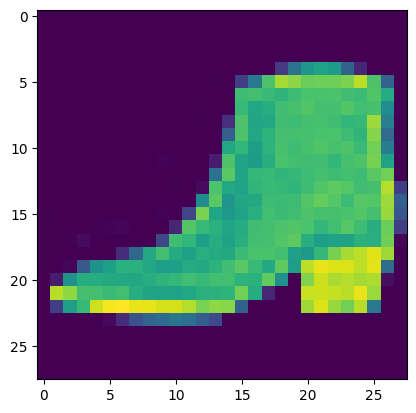

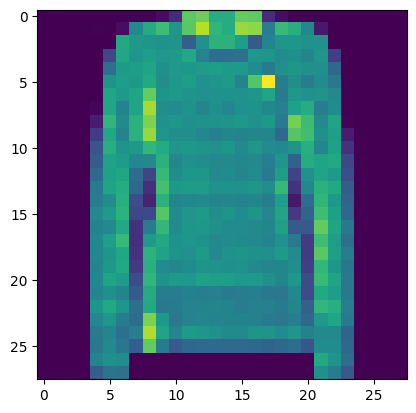

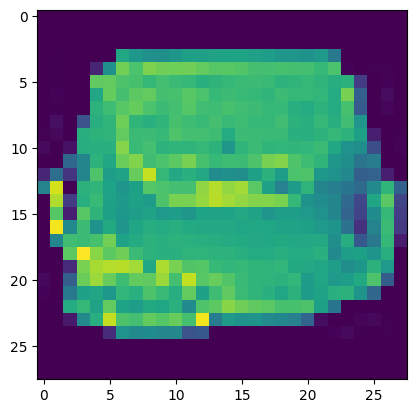

In [28]:
for i, data_ in enumerate(train_loader):
    plt.imshow(data_[0][i, :, :].view(28, 28))
    plt.show()
    if i==3:
        break

# Autoencoder Definition



# Define Model

Here we define our model which us based on Autoencoder class and use the optimizer based on `Adam Optimizer`.

First, We start with a simple Model which only uses Linear layers with Leaky Relu activations.

<div align="center">
       <img src="../assets/img/ae_2.png" width="800px"> </div>

In [29]:
class AutoencoderLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_en_1 = nn.Linear(in_features=28*28, out_features=196)
        self.linear_en_2 = nn.Linear(in_features=196, out_features=98)
        self.linear_de_1 = nn.Linear(in_features=98, out_features=196)
        self.linear_de_2 = nn.Linear(in_features=196, out_features=28*28)

    def forward(self, x):
        encode_1 = F.leaky_relu(self.linear_en_1(x))
        encode_2 = F.leaky_relu(self.linear_en_2(encode_1))
        decode_1 = F.leaky_relu(self.linear_de_1(encode_2))
        decode_2 = F.sigmoid(self.linear_de_2(decode_1))
        return decode_2

In [30]:
model_aal, optimizer, loss_fn = ae.make_model(AutoencoderLinear)

Is our model even working???

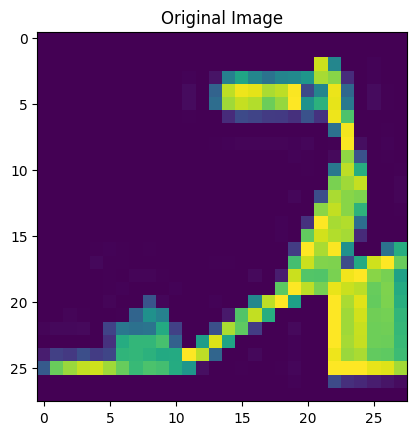

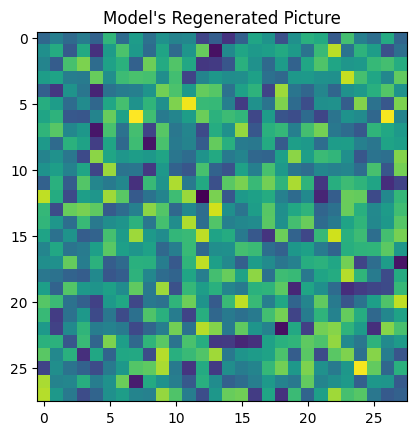

In [31]:
ae.test_model(train_loader, model_aal)

So we are just getting noise, Let's see what happens after a brief training.

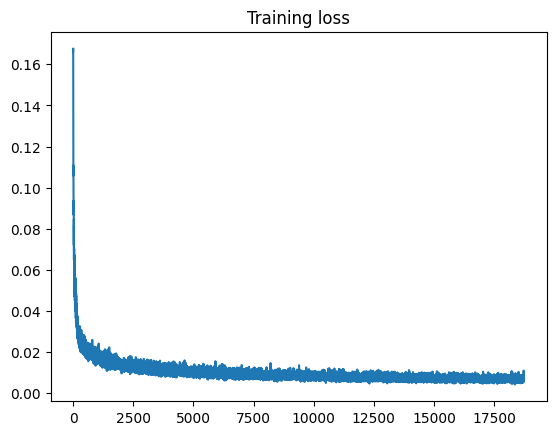

In [32]:
model_aal = ae.train_model(model_aal, optimizer, loss_fn, train_loader, batch_size, epoch_num=10)

Let's test that how much our model has learned to implicate the exact input by seeing the real images

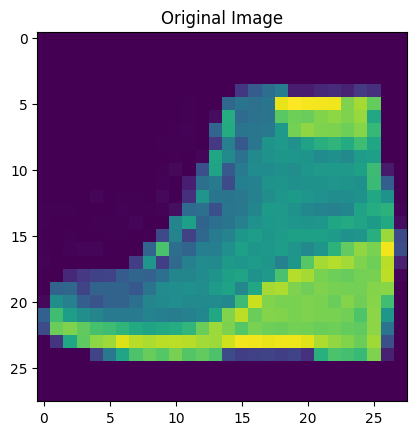

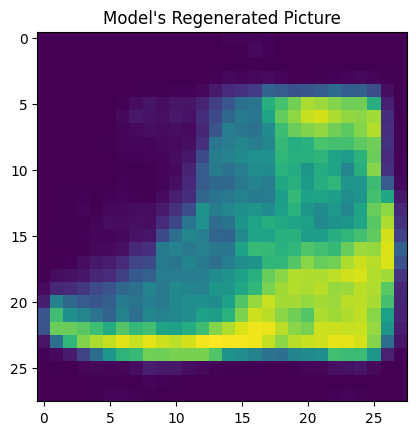

In [33]:
ae.test_model(train_loader, model_aal)

We can See that After 10 epochs of training our model is learning the general shape of the given input. so we are on the right track.

Let's make the linear model a bit dynamic. We add two linear layers which we could adjust the size of compression.

In [34]:
class AutoencoderLinearA(nn.Module):
    def __init__(self, compress_nodes):
        super().__init__()
        self.linear_en_1 = nn.Linear(in_features=28*28, out_features=196)
        self.linear_en_2 = nn.Linear(in_features=196, out_features=98)
        self.linear_de_1 = nn.Linear(in_features=98, out_features=196)
        self.linear_de_2 = nn.Linear(in_features=196, out_features=28*28)
        self.linear_en_c = nn.Linear(in_features=98, out_features=compress_nodes)
        self.linear_de_c = nn.Linear(in_features=compress_nodes, out_features=98)

    def forward(self, x):
        encode_1 = F.leaky_relu(self.linear_en_1(x))
        encode_2 = F.leaky_relu(self.linear_en_2(encode_1))
        encode_c = self.linear_en_c(encode_2)
        decode_c = self.linear_de_c(encode_c)
        decode_1 = F.leaky_relu(self.linear_de_1(decode_c))
        decode_2 = F.sigmoid(self.linear_de_2(decode_1))
        return decode_2

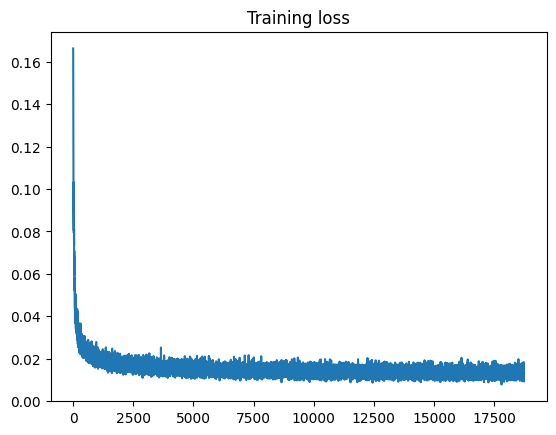

In [35]:
model_aala, optimizer, loss_fn = ae.make_model(AutoencoderLinearA, compress_=10)
model_aala = ae.train_model(model_aala, optimizer, loss_fn, train_loader, batch_size, epoch_num=10)

With a compression level which we compress all the 784 pixels to 10 nodes and then rescale them we still learning the general shape of the item after 10 epochs.

We might get better results if we try and use higher epochs, These results are just for 10 epochs. (Although the chart is showing that the training loss might not increase a lot and we might need to make the model more complicated to decrease the error)

Although we can see that when we decrease the compression nodes we are loosing some data which increases the training error, as you can compare the charts before.

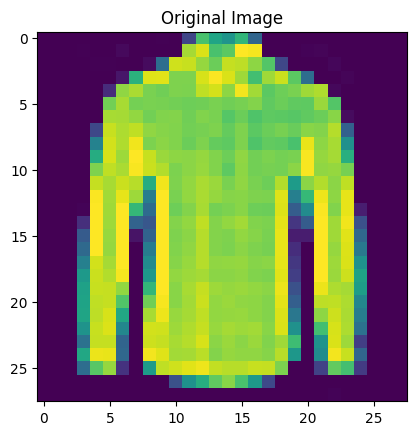

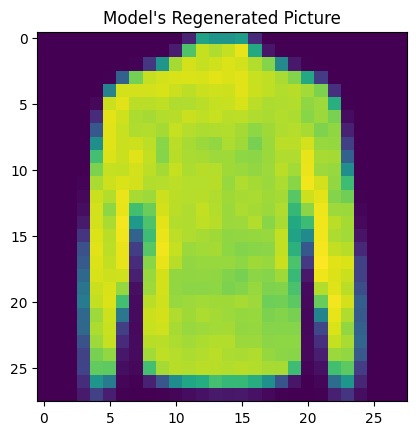

In [36]:
ae.test_model(model_=model_aala, loader_obj=train_loader)

# Autoencoder with CNN

<div align="center">
    <img src="../assets/img/ae_3.png" width="800px"> </div>
(The image is just for showing the structure of)
This Python code defines a convolutional autoencoder class using PyTorch. The autoencoder consists of an encoder and a decoder network.

**Encoder:**
* Takes a 1-Channel image as input.
* Applies a series of convolutional layers with LeakyReLU activations to extract features.
* Uses a flattening layer to convert the feature maps into a linear vector.
* Finally, projects the vector into a latent space representation.

**Decoder:**
* Takes the latent space representation as input.
* Projects it back to the original feature map size using a linear layer and unflattening.
* Applies a series of transposed convolutional layers with LeakyReLU activations to reconstruct the image.
* Uses a sigmoid activation function to output the reconstructed image with pixel values between 0 and 1.

**Forward Pass:**
* Encodes the input image using the encoder.
* Decodes the encoded representation using the decoder.
* Returns the reconstructed image.

In [37]:
# Build the Autoencoder with CNN using the sequential method from pytorch
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(in_features=128*10*10, out_features=144)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=144, out_features=128*10*10),
            nn.Unflatten(1, (128, 10, 10)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(2,2), stride=(2,2)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(5,5), stride=(1,1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

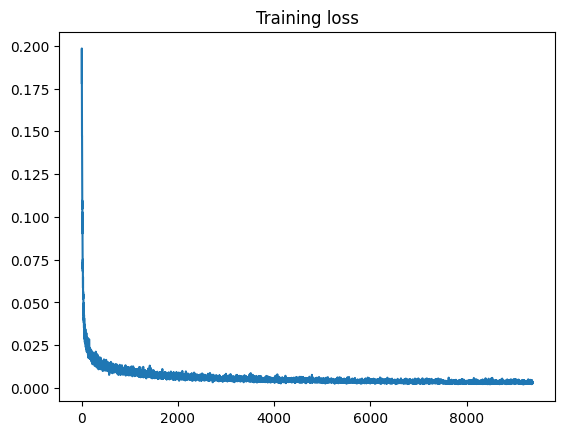

In [38]:
model_cnn, optimizer, loss_fn = ae.make_model(AutoencoderCNN)
model_cnn = ae.train_model(model_cnn, optimizer, loss_fn, train_loader, batch_size, epoch_num=5, model_linear=False)

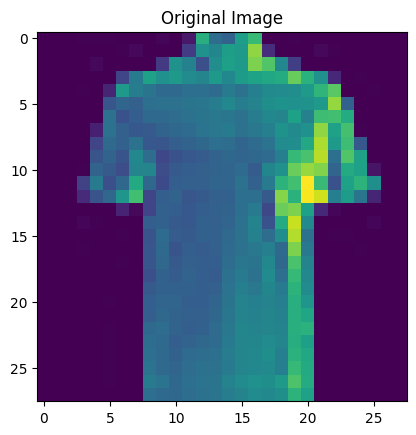

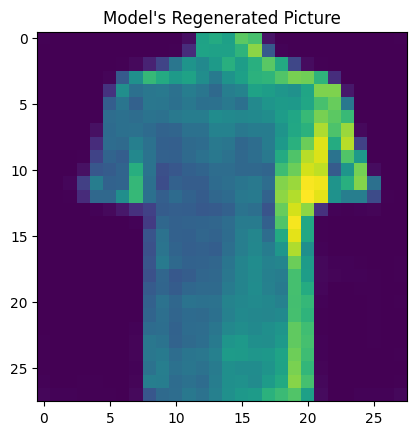

In [39]:
ae.test_model(train_loader, model_cnn, linear=False)

Looks like we have achieved a better result using a CNN Autoencoder with just only 5 epochs but a longer training time. (10 minutes instead of 30 seconds training time)

Let's take a look at the output of the `code layer` which compresses the data, and convert it to a picture to see if there is anything meaningful in there.

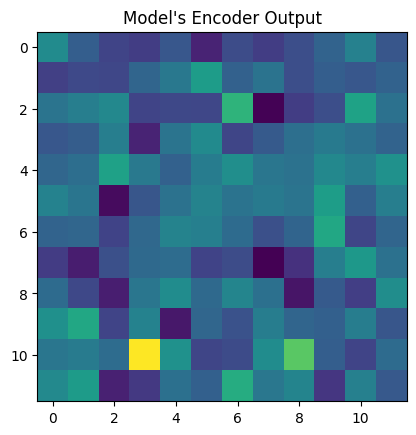

In [40]:
batch_iter = iter(train_loader)
batch_images = next(batch_iter)
tmp_image = batch_images[0][0, 0, :, :]
enc_output = model_cnn.encoder(tmp_image.reshape(1, 1, 28, 28))

# We have 144 Nodes so we can derive a 12*12 picture from it.
plt.imshow(enc_output.detach().numpy().reshape(12, 12))
plt.title("Model's Encoder Output")
plt.show()

## Autoencoders for Data Noise Reduction

Autoencoders have emerged as a powerful tool for mitigating noise in various data modalities. By training a neural network to reconstruct clean data from noisy inputs, these models effectively learn to filter out unwanted disturbances.

A key advantage of autoencoders lies in their ability to capture complex, non-linear relationships within data. This enables them to effectively remove noise while preserving essential features. Moreover, autoencoders are unsupervised learning models, requiring only unlabeled data for training, making them versatile for a wide range of applications.
 
By effectively removing noise, autoencoders can significantly enhance the performance of downstream machine learning models, leading to improved accuracy and robustness.

Let's introduce some noise to the picture and see how our model is working to regenrate the output withouht noise.

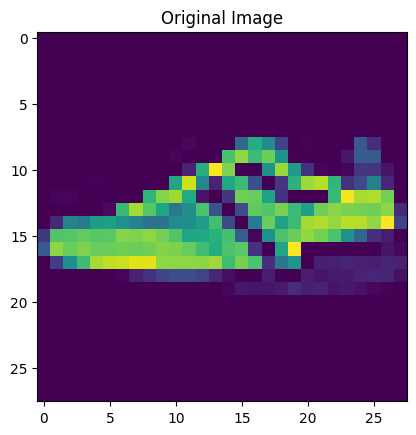

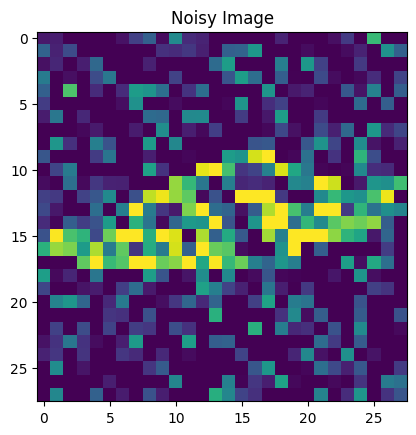

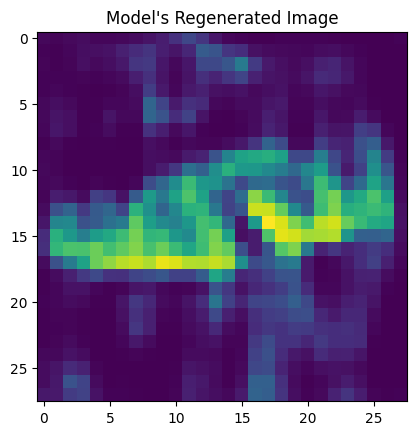

In [41]:
ae.noisy_test(train_loader, model_cnn, linear=False, noise_intensity=0.3)

We have added a lot of noise to our input data and our model was abe to reduce many of them and find the general shape of our original image.

# CIFAR 10

We will try to use the autoencoders with CIFAR10 dataset. This dataset consists of color images with 3 channels and 32*32 size.

Since the images in this dataset has more variety and also has colors in them we need to use a bigger model to be able to distinguisg between pattern and also reproduce the given image with a low loss.

In [18]:
# Load data and make it into chunks
cifar_loader = data_loader.load_cifar_data()

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


Let's check the size of chunks

In [19]:
cifar_loader.dataset.data.shape

(50000, 32, 32, 3)

A quick peek at the images.

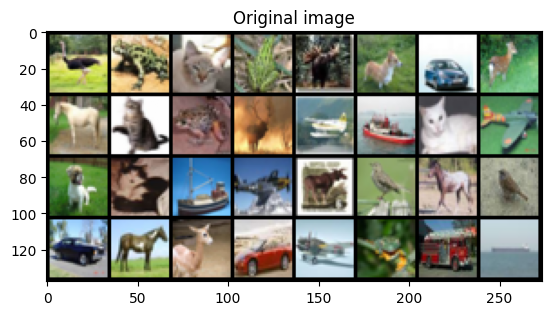

In [21]:
# get some random training images
dataiter = iter(cifar_loader)
images, labels = next(dataiter)

# show images by cinverting batches to grids
ae.image_show(images, "Original image")

In [22]:
# We use a similar architectur as before just tweaking some numbers for a bigger model
# since these pictures has 3 channels and we need to compress more data in our model
# We also add some padding to take into account the information that is stored on the edges of the pictures.
class AutoencoderCNNCIF(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4,4), stride=(1,1), padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3,3), stride=(2,2)),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(in_features=512*6*6, out_features=100)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=100, out_features=512*6*6),
            nn.Unflatten(1, (512, 6, 6)),
            nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=(3,3), stride=(2,2)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(5,5), stride=(1,1)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(5,5), stride=(2,2), padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=(4,4), stride=(1,1), padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

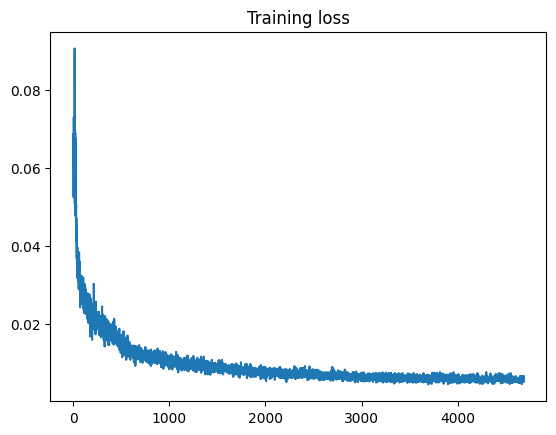

In [23]:
model_cifar, optimizer_cifar, loss_cifar = ae.make_model(AutoencoderCNNCIF, .001)
model_cifar = ae.train_model(model_cifar, optimizer_cifar, loss_cifar, cifar_loader, 32, 3, False)

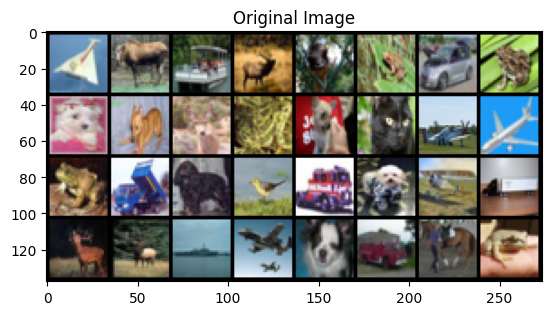

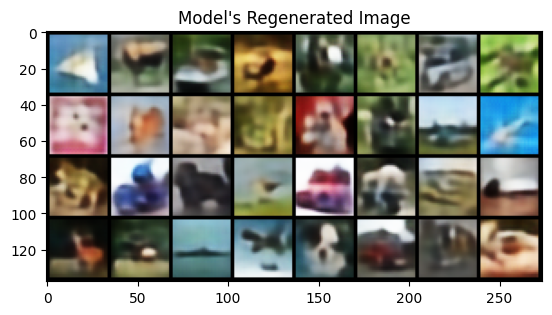

In [24]:
# Test the output model by feeding random batches to it and get the output
ae.test_cifar(model_cifar, cifar_loader)

Our CNN model has been able to recontsruct mostly many of the details of the pictures, Although the output are a bit blury.

We can try and add other layers to the model in order to increase its ability to find the patterns in data and preserve them while compressing the pictures.

Another reason that our model is generating blury images could be the `code layer`, If it is small for this type of data it could lose some details and in recontructing we won't be able to reover that specific data.